In [134]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plot
from scipy.stats import poisson
from scipy.stats import gamma
from scipy.stats import beta
from scipy.stats import norm
import pandas as pd
import itertools
from scipy.stats import dirichlet
import import_ipynb
from team_model import predict_fixtures, import_fixture_lists, import_fixture_list

In [135]:
# create form matrix
def find_form(fixtures_list):
    
    N = np.shape(fixtures_list)[0]
    goals_ht = fixtures_list[:, 2]
    goals_at = fixtures_list[:, 3]
    teams_ht = fixtures_list[:, 0]
    teams_at = fixtures_list[:, 1]
    
    teams_for_season = np.unique(teams_ht)
    
    points = np.zeros((38, 20))
    team_count = np.zeros(20)
    for i in range(N):
        points[team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)].astype(int), np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] = (3 * (goals_ht[i] > goals_at[i])) + (goals_ht[i] == goals_at[i])
        points[team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)].astype(int), np.where(teams_for_season == teams_at[i])[0][0].astype(int)] = (3 * (goals_ht[i] < goals_at[i])) + (goals_ht[i] == goals_at[i])
        team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] += 1
        team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)] += 1
    form = np.ones((38, 20)) * 7.5
    for j in range(20):
        form[5:, j] = np.cumsum(points[:, j])[5:] - np.cumsum(points[:, j])[:(38 - 5)]
    
    team_count = np.zeros(20)
    mat_form = np.zeros((N, 2))
    for i in range(N):
        ind_ht = np.where(teams == teams_ht[i])[0][0].astype(int)
        ind_at = np.where(teams == teams_at[i])[0][0].astype(int)
        ind_for_season_ht = np.where(teams_for_season == teams_ht[i])[0][0].astype(int)
        ind_for_season_at = np.where(teams_for_season == teams_at[i])[0][0].astype(int)
        mat_form[i, 0] = form[team_count[ind_for_season_ht].astype(int), ind_for_season_ht]
        mat_form[i, 1] = form[team_count[ind_for_season_at].astype(int), ind_for_season_at]
        team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] += 1
        team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)] += 1
    
    return(teams_for_season, mat_form)

### Optimization of players

#### Probability functions of points scoring

In [151]:
def sample_clean_sheet_for_team(lambda_2):
    return(np.random.poisson(lambda_2) == 0)

def sample_mins_played(a, b, a_games, b_games, starting=None):
    if starting == None:
        return(np.random.choice([1, 0], 1, p=np.random.dirichlet([a_games, b_games]))[0] * np.min([np.random.poisson(np.random.gamma(a, 1 / b)), 90]))
    elif starting == True:
        return(np.min([np.random.poisson(np.random.gamma(a, 1 / b)), 90]))
    elif starting == False:
        return(0)

def sample_goals_and_assists(a, b, c, n, mins_played):
    t_goals = np.random.uniform(0, 90, n)  # times of goals
    n_goals = np.sum(t_goals <= mins_played)
    d = np.random.dirichlet(np.array([a, b, c]))  # sample hyperparameters
    if (n_goals > 0):
        samples = np.random.choice(np.array([0, 1, 2]), n_goals, p=d)
        return(sum(samples == 0), sum(samples == 1))
    else:
        return(0, 0)

def sample_clean_sheet_points(goals_conceded, mins_played):
    return(int(mins_played > 60) * int(goals_conceded == 0))

def sample_mins_points(mins_played):
    return(int(mins_played > 60) + int(mins_played >= 1))

In [137]:
def get_players(all_players_params, team_sel):
    ind = all_players_params.index[all_players_params['team'] == team_sel]
    return(ind)

In [138]:
def ComputeExpectedPoints(fixtures_list, teams, all_players_params, all_teams_params,
                          zerooutbottom=0, Niter=250, additionalstats=False, form=None):
    
    # param data sets are pd Data Frames
    
    # Without bonus for now and goals conceded points
    
    # preallocate points for each iteration
    points = np.zeros((Niter, len(all_players_params.index)))
    clean_sheets = np.zeros((Niter, len(all_players_params.index)))
    goals_scored = np.zeros((Niter, len(all_players_params.index)))
    mplayed = np.zeros((Niter, len(all_players_params.index)))

    # mean and std of team hyperparameters
    mu = (all_teams_params.as_matrix())[0, :]
    a = (all_teams_params.as_matrix())[1:(len(teams) + 1), :]
    d = (all_teams_params.as_matrix())[(len(teams) + 1):((2 * len(teams)) + 1), :]
    alpha = (all_teams_params.as_matrix())[((2 * len(teams)) + 1), :]

    for l in range(Niter):
        
        # preallocate form array
        team_points = np.zeros((38, len(teams)))
        team_counter = np.zeros(len(teams))
        
        for i in range(np.shape(fixtures_list)[0]):
            
            # find teams for each fixture
            h_team = fixtures_list[i, 0]
            a_team = fixtures_list[i, 1]
            
            # compute form
            if hasattr(form, '__len__'):
                form_h = form[i, 0]
                form_a = form[i, 1]
            else:
                if team_counter[np.where(h_team == teams)[0][0]] > 5:
                    form_h = (np.cumsum(team_points[:, int(np.where(h_team == teams)[0][0])])[5:] - np.cumsum(team_points[:, int(np.where(h_team == teams)[0][0])])[:(38 - 5)])[int(team_counter[np.where(h_team == teams)[0][0]] - 1 - 5)]
                else:
                    form_h = 7.5
                if team_counter[np.where(a_team == teams)[0][0]] > 5:
                    form_a = (np.cumsum(team_points[:, int(np.where(a_team == teams)[0][0])])[5:] - np.cumsum(team_points[:, int(np.where(a_team == teams)[0][0])])[:(38 - 5)])[int(team_counter[np.where(a_team == teams)[0][0]] - 1 - 5)]
                else:
                    form_a = 7.5
            
            # sample lambdas for team performance - sample from team hyperparameters
            lambdas = predict_fixtures(np.reshape(fixtures_list[i, :2], ((1, 2))),
                                       np.reshape(np.array([form_h, form_a]), ((1, 2))),
                                       teams, mu, a, d, alpha, uncertainty=True)
            
            # sample score
            h_n = np.random.poisson(lambdas[0][0])
            a_n = np.random.poisson(lambdas[1][0])
            
            # compute incremental team points
            team_points[int(team_counter[np.where(h_team == teams)[0][0]]),
                        int(np.where(h_team == teams)[0][0])] += (3 * (h_n > a_n)) + (h_n == a_n)
            team_points[int(team_counter[np.where(a_team == teams)[0][0]]),
                        int(np.where(a_team == teams)[0][0])] += (3 * (h_n < a_n)) + (h_n == a_n)
            
            team_counter[np.where(h_team == teams)[0][0]] += 1
            team_counter[np.where(a_team == teams)[0][0]] += 1
            
            # find all players in these teams
            h_players = get_players(all_players_params, h_team)
            a_players = get_players(all_players_params, a_team)
            
            # loop over players
            for j in range(len(h_players)):
                
                # predefine scalings for points
                if all_players_params.loc[all_players_params.index[h_players[j]], 'position'] == "GKP":
                    scaling = np.array([6., 3., 4.])
                if all_players_params.loc[all_players_params.index[h_players[j]], 'position'] == "DEF":
                    scaling = np.array([6., 3., 4.])
                if all_players_params.loc[all_players_params.index[h_players[j]], 'position'] == "MID":
                    scaling = np.array([5., 3., 1.])
                if all_players_params.loc[all_players_params.index[h_players[j]], 'position'] == "FWD":
                    scaling = np.array([4., 3., 0.])
                
                # sample mins played
                mins_played = sample_mins_played(all_players_params.loc[all_players_params.index[h_players[j]], 'a_mins'],
                                                 all_players_params.loc[all_players_params.index[h_players[j]], 'b_mins'],
                                                 all_players_params.loc[all_players_params.index[h_players[j]], 'a_games'],
                                                 all_players_params.loc[all_players_params.index[h_players[j]], 'b_games'])
                
                goa, assi = sample_goals_and_assists(all_players_params.loc[all_players_params.index[h_players[j]], 'a_goals'],
                                                         all_players_params.loc[all_players_params.index[h_players[j]], 'b_goals'],
                                                         all_players_params.loc[all_players_params.index[h_players[j]], 'c_goals'],
                                                         h_n, mins_played)
                points[l, h_players[j]] += ((goa * scaling[0]) + (assi * scaling[1]))  # goals and assists
                csp = sample_clean_sheet_points(a_n, mins_played)
                points[l, h_players[j]] += ((scaling[2] * csp) +
                                            (sample_mins_points(mins_played)))
                clean_sheets[l, h_players[j]] += csp
                goals_scored[l, h_players[j]] += goa
                mplayed[l, h_players[j]] += mins_played
            
            for j in range(len(a_players)):
                
                # predefine scalings for points
                if all_players_params.loc[all_players_params.index[a_players[j]], 'position'] == "GKP":
                    scaling = np.array([6., 3., 4.])
                if all_players_params.loc[all_players_params.index[a_players[j]], 'position'] == "DEF":
                    scaling = np.array([6., 3., 4.])
                if all_players_params.loc[all_players_params.index[a_players[j]], 'position'] == "MID":
                    scaling = np.array([5., 3., 1.])
                if all_players_params.loc[all_players_params.index[a_players[j]], 'position'] == "FWD":
                    scaling = np.array([4., 3., 0.])
                
                # sample mins played
                mins_played = sample_mins_played(all_players_params.loc[all_players_params.index[a_players[j]], 'a_mins'],
                                                 all_players_params.loc[all_players_params.index[a_players[j]], 'b_mins'],
                                                 all_players_params.loc[all_players_params.index[a_players[j]], 'a_games'],
                                                 all_players_params.loc[all_players_params.index[a_players[j]], 'b_games'])
                
                goa, assi = sample_goals_and_assists(all_players_params.loc[all_players_params.index[a_players[j]], 'a_goals'],
                                                         all_players_params.loc[all_players_params.index[a_players[j]], 'b_goals'],
                                                         all_players_params.loc[all_players_params.index[a_players[j]], 'c_goals'],
                                                         a_n, mins_played)
                points[l, a_players[j]] += ((goa * scaling[0]) + (assi * scaling[1]))  # goals and assists
                csp = sample_clean_sheet_points(h_n, mins_played)
                points[l, a_players[j]] += ((scaling[2] * csp) +
                                            (sample_mins_points(mins_played)))
                clean_sheets[l, a_players[j]] += csp
                goals_scored[l, a_players[j]] += goa
                mplayed[l, a_players[j]] += mins_played

        print('---')
        print('Realisation ', l)
        print('Top Points Scorers: ', all_players_params.loc[all_players_params.index[np.argsort(points[l, :])[-5:].astype(int)], 'player'],
              ' with ', np.sort(points[l, :])[-5:], ' points')

    if zerooutbottom > 0:
        for l in range(Niter):
            points[l, np.argsort(points[l, :])[:zerooutbottom]] = 0  # to account for bench players when simulating team performance

    expected_points = np.mean(points, axis=0)
    sd_points = np.std(points, axis=0)
    cs = np.mean(clean_sheets, axis=0)
    gs = np.mean(goals_scored, axis=0)
    mp = np.mean(mplayed, axis=0)

    if additionalstats:
        return(expected_points, sd_points, cs, gs, mp)
    else:
        return(expected_points, sd_points)

### Historical fitting

In [139]:
form = np.ones((380, 2)) * 7.5

all_players_params = pd.read_csv("../parameters/all_players_params.csv")
all_teams_params = pd.read_csv("../parameters/all_teams_params.csv", header=None)
teams = pd.read_csv("../parameters/all_teams.csv", header=None).values[:, 0]

In [140]:
# fixture list this season to predict
fixture_list_this_season = (pd.read_csv("../data/prem_results_20192020.csv", header=None)).values

In [131]:
# small fixture list - use for optimization for any particular gameweek
#fixture_list_this_season = (pd.read_csv("prem_results_20182019.csv", header=None).as_matrix())[:10, :]
#print(fixture_list_this_season)

#type in current form here
#form=....

In [141]:
C, S, CS, G, MP = ComputeExpectedPoints(fixture_list_this_season, teams, all_players_params, all_teams_params, Niter=2000,
                                        additionalstats=True)

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


---
Realisation  0
Top Points Scorers:  134        Eden Hazard
329    Raheem Sterling
828       Matt Doherty
306         Sadio Mané
310      Mohamed Salah
Name: player, dtype: object  with  [176. 182. 193. 198. 226.]  points
---
Realisation  1
Top Points Scorers:  828       Matt Doherty
721        Lucas Digne
130      Marcos Alonso
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [183. 184. 197. 212. 306.]  points
---
Realisation  2
Top Points Scorers:  516    Christian Eriksen
329      Raheem Sterling
310        Mohamed Salah
306           Sadio Mané
828         Matt Doherty
Name: player, dtype: object  with  [185. 190. 194. 202. 210.]  points
---
Realisation  3
Top Points Scorers:  828         Matt Doherty
516    Christian Eriksen
306           Sadio Mané
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [191. 203. 224. 239. 269.]  points
---
Realisation  4
Top Points Scorers:  315     Virgil van Dijk
306          Sad

---
Realisation  34
Top Points Scorers:  516    Christian Eriksen
329      Raheem Sterling
522           Harry Kane
721          Lucas Digne
310        Mohamed Salah
Name: player, dtype: object  with  [177. 185. 198. 203. 266.]  points
---
Realisation  35
Top Points Scorers:  306               Sadio Mané
772    Alisson Ramses Becker
339            Sergio Agüero
329          Raheem Sterling
310            Mohamed Salah
Name: player, dtype: object  with  [177. 181. 202. 220. 223.]  points
---
Realisation  36
Top Points Scorers:  134          Eden Hazard
522           Harry Kane
128    César Azpilicueta
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [164. 169. 176. 210. 219.]  points
---
Realisation  37
Top Points Scorers:  175    Luka Milivojevic
522          Harry Kane
721         Lucas Digne
372          Paul Pogba
310       Mohamed Salah
Name: player, dtype: object  with  [173. 178. 196. 220. 243.]  points
---
Realisation  38
Top Points Scorers:  

---
Realisation  69
Top Points Scorers:  306           Sadio Mané
522           Harry Kane
329      Raheem Sterling
516    Christian Eriksen
310        Mohamed Salah
Name: player, dtype: object  with  [175. 180. 182. 205. 255.]  points
---
Realisation  70
Top Points Scorers:  339             Sergio Agüero
563    Richarlison de Andrade
516         Christian Eriksen
310             Mohamed Salah
329           Raheem Sterling
Name: player, dtype: object  with  [181. 193. 200. 215. 257.]  points
---
Realisation  71
Top Points Scorers:  134        Eden Hazard
339      Sergio Agüero
828       Matt Doherty
310      Mohamed Salah
329    Raheem Sterling
Name: player, dtype: object  with  [184. 191. 210. 234. 263.]  points
---
Realisation  72
Top Points Scorers:  721          Lucas Digne
128    César Azpilicueta
306           Sadio Mané
276          Jamie Vardy
310        Mohamed Salah
Name: player, dtype: object  with  [185. 195. 196. 196. 197.]  points
---
Realisation  73
Top Points Scorers:  

---
Realisation  104
Top Points Scorers:  128    César Azpilicueta
306           Sadio Mané
130        Marcos Alonso
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [176. 205. 206. 224. 249.]  points
---
Realisation  105
Top Points Scorers:  840         Raúl Jiménez
128    César Azpilicueta
306           Sadio Mané
310        Mohamed Salah
329      Raheem Sterling
Name: player, dtype: object  with  [174. 180. 185. 224. 230.]  points
---
Realisation  106
Top Points Scorers:  316    Andrew Robertson
134         Eden Hazard
329     Raheem Sterling
306          Sadio Mané
310       Mohamed Salah
Name: player, dtype: object  with  [174. 179. 182. 187. 188.]  points
---
Realisation  107
Top Points Scorers:  817    Felipe Anderson Pereira Gomes
175                 Luka Milivojevic
315                  Virgil van Dijk
329                  Raheem Sterling
310                    Mohamed Salah
Name: player, dtype: object  with  [169. 171. 176. 190. 246.]  poin

---
Realisation  139
Top Points Scorers:  763    Ricardo Domingos Barbosa Pereira
522                          Harry Kane
306                          Sadio Mané
329                     Raheem Sterling
310                       Mohamed Salah
Name: player, dtype: object  with  [178. 181. 199. 222. 269.]  points
---
Realisation  140
Top Points Scorers:  516         Christian Eriksen
563    Richarlison de Andrade
128         César Azpilicueta
329           Raheem Sterling
310             Mohamed Salah
Name: player, dtype: object  with  [172. 174. 174. 184. 213.]  points
---
Realisation  141
Top Points Scorers:  128    César Azpilicueta
329      Raheem Sterling
130        Marcos Alonso
372           Paul Pogba
310        Mohamed Salah
Name: player, dtype: object  with  [167. 167. 179. 182. 240.]  points
---
Realisation  142
Top Points Scorers:  828                        Matt Doherty
763    Ricardo Domingos Barbosa Pereira
134                         Eden Hazard
329                     Rah

---
Realisation  173
Top Points Scorers:  763    Ricardo Domingos Barbosa Pereira
306                          Sadio Mané
316                    Andrew Robertson
329                     Raheem Sterling
310                       Mohamed Salah
Name: player, dtype: object  with  [171. 172. 180. 185. 219.]  points
---
Realisation  174
Top Points Scorers:  721        Lucas Digne
828       Matt Doherty
134        Eden Hazard
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [166. 167. 179. 198. 214.]  points
---
Realisation  175
Top Points Scorers:  828              Matt Doherty
563    Richarlison de Andrade
310             Mohamed Salah
522                Harry Kane
329           Raheem Sterling
Name: player, dtype: object  with  [170. 172. 177. 207. 231.]  points
---
Realisation  176
Top Points Scorers:  339      Sergio Agüero
341        Kyle Walker
329    Raheem Sterling
310      Mohamed Salah
306         Sadio Mané
Name: player, dtype: object  with  [172. 1

---
Realisation  207
Top Points Scorers:  341          Kyle Walker
516    Christian Eriksen
306           Sadio Mané
310        Mohamed Salah
329      Raheem Sterling
Name: player, dtype: object  with  [173. 179. 181. 183. 199.]  points
---
Realisation  208
Top Points Scorers:  563    Richarlison de Andrade
315           Virgil van Dijk
828              Matt Doherty
329           Raheem Sterling
310             Mohamed Salah
Name: player, dtype: object  with  [172. 172. 174. 203. 240.]  points
---
Realisation  209
Top Points Scorers:  134          Eden Hazard
128    César Azpilicueta
306           Sadio Mané
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [181. 182. 191. 219. 247.]  points
---
Realisation  210
Top Points Scorers:  828        Matt Doherty
311     Roberto Firmino
522          Harry Kane
175    Luka Milivojevic
310       Mohamed Salah
Name: player, dtype: object  with  [166. 167. 171. 180. 216.]  points
---
Realisation  211
Top Points 

---
Realisation  242
Top Points Scorers:  134                  Eden Hazard
322    Ederson Santana de Moraes
826                   Willy Boly
828                 Matt Doherty
310                Mohamed Salah
Name: player, dtype: object  with  [172. 172. 181. 208. 224.]  points
---
Realisation  243
Top Points Scorers:  772    Alisson Ramses Becker
828             Matt Doherty
315          Virgil van Dijk
306               Sadio Mané
310            Mohamed Salah
Name: player, dtype: object  with  [164. 166. 175. 188. 290.]  points
---
Realisation  244
Top Points Scorers:  18        Granit Xhaka
329    Raheem Sterling
134        Eden Hazard
306         Sadio Mané
310      Mohamed Salah
Name: player, dtype: object  with  [165. 190. 196. 228. 243.]  points
---
Realisation  245
Top Points Scorers:  128                César Azpilicueta
329                  Raheem Sterling
817    Felipe Anderson Pereira Gomes
134                      Eden Hazard
310                    Mohamed Salah
Name: player

---
Realisation  275
Top Points Scorers:  316             Andrew Robertson
31     Pierre-Emerick Aubameyang
329              Raheem Sterling
306                   Sadio Mané
310                Mohamed Salah
Name: player, dtype: object  with  [181. 189. 207. 231. 263.]  points
---
Realisation  276
Top Points Scorers:  775         David de Gea
128    César Azpilicueta
828         Matt Doherty
516    Christian Eriksen
310        Mohamed Salah
Name: player, dtype: object  with  [154. 154. 158. 183. 253.]  points
---
Realisation  277
Top Points Scorers:  130      Marcos Alonso
522         Harry Kane
828       Matt Doherty
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [183. 184. 186. 191. 210.]  points
---
Realisation  278
Top Points Scorers:  828         Matt Doherty
175     Luka Milivojevic
128    César Azpilicueta
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [174. 175. 188. 201. 235.]  points
---
Realisation  279
T

---
Realisation  309
Top Points Scorers:  372         Paul Pogba
306         Sadio Mané
341        Kyle Walker
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [171. 172. 176. 184. 235.]  points
---
Realisation  310
Top Points Scorers:  516    Christian Eriksen
339        Sergio Agüero
828         Matt Doherty
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [171. 182. 218. 221. 253.]  points
---
Realisation  311
Top Points Scorers:  339      Sergio Agüero
306         Sadio Mané
828       Matt Doherty
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [170. 174. 189. 244. 248.]  points
---
Realisation  312
Top Points Scorers:  516    Christian Eriksen
329      Raheem Sterling
721          Lucas Digne
134          Eden Hazard
310        Mohamed Salah
Name: player, dtype: object  with  [175. 182. 200. 217. 251.]  points
---
Realisation  313
Top Points Scorers:  516    Christian Eriksen
329  

---
Realisation  344
Top Points Scorers:  306       Sadio Mané
826       Willy Boly
134      Eden Hazard
828     Matt Doherty
310    Mohamed Salah
Name: player, dtype: object  with  [177. 183. 195. 203. 204.]  points
---
Realisation  345
Top Points Scorers:  134        Eden Hazard
372         Paul Pogba
522         Harry Kane
310      Mohamed Salah
329    Raheem Sterling
Name: player, dtype: object  with  [176. 181. 195. 211. 222.]  points
---
Realisation  346
Top Points Scorers:  220     Gylfi Sigurdsson
128    César Azpilicueta
306           Sadio Mané
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [175. 175. 188. 203. 327.]  points
---
Realisation  347
Top Points Scorers:  134          Eden Hazard
128    César Azpilicueta
306           Sadio Mané
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [182. 190. 197. 215. 223.]  points
---
Realisation  348
Top Points Scorers:  330        David Silva
130      Marcos A

---
Realisation  378
Top Points Scorers:  517    Bamidele Alli
522       Harry Kane
339    Sergio Agüero
310    Mohamed Salah
828     Matt Doherty
Name: player, dtype: object  with  [174. 176. 182. 185. 192.]  points
---
Realisation  379
Top Points Scorers:  522                   Harry Kane
306                   Sadio Mané
31     Pierre-Emerick Aubameyang
339                Sergio Agüero
310                Mohamed Salah
Name: player, dtype: object  with  [172. 183. 185. 193. 241.]  points
---
Realisation  380
Top Points Scorers:  522       Harry Kane
130    Marcos Alonso
306       Sadio Mané
134      Eden Hazard
310    Mohamed Salah
Name: player, dtype: object  with  [175. 179. 187. 211. 240.]  points
---
Realisation  381
Top Points Scorers:  322    Ederson Santana de Moraes
329              Raheem Sterling
721                  Lucas Digne
828                 Matt Doherty
310                Mohamed Salah
Name: player, dtype: object  with  [171. 181. 190. 193. 248.]  points
---
Realisat

---
Realisation  412
Top Points Scorers:  339        Sergio Agüero
522           Harry Kane
134          Eden Hazard
516    Christian Eriksen
310        Mohamed Salah
Name: player, dtype: object  with  [190. 192. 192. 202. 202.]  points
---
Realisation  413
Top Points Scorers:  134          Eden Hazard
339        Sergio Agüero
128    César Azpilicueta
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [194. 203. 209. 216. 224.]  points
---
Realisation  414
Top Points Scorers:  276        Jamie Vardy
721        Lucas Digne
134        Eden Hazard
310      Mohamed Salah
329    Raheem Sterling
Name: player, dtype: object  with  [169. 171. 183. 207. 223.]  points
---
Realisation  415
Top Points Scorers:  372         Paul Pogba
306         Sadio Mané
329    Raheem Sterling
134        Eden Hazard
310      Mohamed Salah
Name: player, dtype: object  with  [161. 168. 184. 187. 207.]  points
---
Realisation  416
Top Points Scorers:  316    Andrew Robertson
267   

---
Realisation  447
Top Points Scorers:  276        Jamie Vardy
339      Sergio Agüero
840       Raúl Jiménez
310      Mohamed Salah
329    Raheem Sterling
Name: player, dtype: object  with  [163. 164. 176. 204. 215.]  points
---
Realisation  448
Top Points Scorers:  329    Raheem Sterling
306         Sadio Mané
339      Sergio Agüero
828       Matt Doherty
310      Mohamed Salah
Name: player, dtype: object  with  [184. 186. 186. 194. 218.]  points
---
Realisation  449
Top Points Scorers:  316     Andrew Robertson
128    César Azpilicueta
826           Willy Boly
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [169. 182. 183. 195. 266.]  points
---
Realisation  450
Top Points Scorers:  341          Kyle Walker
329      Raheem Sterling
128    César Azpilicueta
134          Eden Hazard
310        Mohamed Salah
Name: player, dtype: object  with  [173. 177. 181. 185. 199.]  points
---
Realisation  451
Top Points Scorers:  128    César Azpilicueta
337  

---
Realisation  481
Top Points Scorers:  339        Sergio Agüero
306           Sadio Mané
128    César Azpilicueta
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [158. 168. 178. 192. 258.]  points
---
Realisation  482
Top Points Scorers:  175                    Luka Milivojevic
128                   César Azpilicueta
763    Ricardo Domingos Barbosa Pereira
329                     Raheem Sterling
310                       Mohamed Salah
Name: player, dtype: object  with  [160. 164. 179. 197. 262.]  points
---
Realisation  483
Top Points Scorers:  522                   Harry Kane
22           Alexandre Lacazette
43                    Nathan Aké
31     Pierre-Emerick Aubameyang
310                Mohamed Salah
Name: player, dtype: object  with  [167. 171. 171. 175. 198.]  points
---
Realisation  484
Top Points Scorers:  828         Matt Doherty
516    Christian Eriksen
721          Lucas Digne
306           Sadio Mané
310        Mohamed Salah
Name: p

---
Realisation  515
Top Points Scorers:  817    Felipe Anderson Pereira Gomes
721                      Lucas Digne
840                     Raúl Jiménez
828                     Matt Doherty
310                    Mohamed Salah
Name: player, dtype: object  with  [164. 173. 179. 211. 223.]  points
---
Realisation  516
Top Points Scorers:  276        Jamie Vardy
134        Eden Hazard
329    Raheem Sterling
310      Mohamed Salah
130      Marcos Alonso
Name: player, dtype: object  with  [176. 179. 186. 190. 191.]  points
---
Realisation  517
Top Points Scorers:  276                  Jamie Vardy
372                   Paul Pogba
341                  Kyle Walker
310                Mohamed Salah
322    Ederson Santana de Moraes
Name: player, dtype: object  with  [173. 178. 180. 181. 184.]  points
---
Realisation  518
Top Points Scorers:  522                Harry Kane
563    Richarlison de Andrade
329           Raheem Sterling
134               Eden Hazard
310             Mohamed Salah
Name: p

---
Realisation  549
Top Points Scorers:  316     Andrew Robertson
828         Matt Doherty
516    Christian Eriksen
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [173. 185. 192. 250. 261.]  points
---
Realisation  550
Top Points Scorers:  329    Raheem Sterling
339      Sergio Agüero
828       Matt Doherty
306         Sadio Mané
310      Mohamed Salah
Name: player, dtype: object  with  [179. 179. 182. 229. 280.]  points
---
Realisation  551
Top Points Scorers:  721        Lucas Digne
134        Eden Hazard
339      Sergio Agüero
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [181. 186. 190. 221. 257.]  points
---
Realisation  552
Top Points Scorers:  826         Willy Boly
828       Matt Doherty
315    Virgil van Dijk
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [180. 184. 209. 224. 322.]  points
---
Realisation  553
Top Points Scorers:  516    Christian Eriksen
128    César Az

---
Realisation  584
Top Points Scorers:  329      Raheem Sterling
306           Sadio Mané
522           Harry Kane
516    Christian Eriksen
310        Mohamed Salah
Name: player, dtype: object  with  [181. 205. 205. 215. 215.]  points
---
Realisation  585
Top Points Scorers:  306         Sadio Mané
828       Matt Doherty
517      Bamidele Alli
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [172. 176. 181. 208. 245.]  points
---
Realisation  586
Top Points Scorers:  134         Eden Hazard
329     Raheem Sterling
316    Andrew Robertson
306          Sadio Mané
310       Mohamed Salah
Name: player, dtype: object  with  [179. 182. 189. 192. 228.]  points
---
Realisation  587
Top Points Scorers:  306         Sadio Mané
276        Jamie Vardy
329    Raheem Sterling
134        Eden Hazard
310      Mohamed Salah
Name: player, dtype: object  with  [172. 179. 186. 197. 244.]  points
---
Realisation  588
Top Points Scorers:  339      Sergio Agüero
276        J

---
Realisation  619
Top Points Scorers:  329      Raheem Sterling
134          Eden Hazard
840         Raúl Jiménez
128    César Azpilicueta
310        Mohamed Salah
Name: player, dtype: object  with  [173. 178. 180. 182. 256.]  points
---
Realisation  620
Top Points Scorers:  828             Matt Doherty
772    Alisson Ramses Becker
316         Andrew Robertson
329          Raheem Sterling
310            Mohamed Salah
Name: player, dtype: object  with  [165. 170. 171. 225. 228.]  points
---
Realisation  621
Top Points Scorers:  128    César Azpilicueta
522           Harry Kane
130        Marcos Alonso
828         Matt Doherty
310        Mohamed Salah
Name: player, dtype: object  with  [182. 185. 192. 193. 196.]  points
---
Realisation  622
Top Points Scorers:  167    Patrick van Aanholt
828           Matt Doherty
175       Luka Milivojevic
329        Raheem Sterling
372             Paul Pogba
Name: player, dtype: object  with  [161. 165. 181. 198. 228.]  points
---
Realisation  623
T

---
Realisation  653
Top Points Scorers:  306         Sadio Mané
315    Virgil van Dijk
67         Shane Duffy
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [162. 164. 166. 185. 219.]  points
---
Realisation  654
Top Points Scorers:  310       Mohamed Salah
341         Kyle Walker
220    Gylfi Sigurdsson
134         Eden Hazard
329     Raheem Sterling
Name: player, dtype: object  with  [172. 173. 177. 179. 219.]  points
---
Realisation  655
Top Points Scorers:  52         Ryan Fraser
306         Sadio Mané
522         Harry Kane
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [161. 162. 173. 176. 224.]  points
---
Realisation  656
Top Points Scorers:  306         Sadio Mané
339      Sergio Agüero
134        Eden Hazard
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [181. 186. 193. 197. 265.]  points
---
Realisation  657
Top Points Scorers:  175    Luka Milivojevic
339       Sergio Agüe

---
Realisation  688
Top Points Scorers:  826         Willy Boly
134        Eden Hazard
310      Mohamed Salah
522         Harry Kane
329    Raheem Sterling
Name: player, dtype: object  with  [182. 184. 205. 208. 219.]  points
---
Realisation  689
Top Points Scorers:  828       Matt Doherty
134        Eden Hazard
522         Harry Kane
310      Mohamed Salah
329    Raheem Sterling
Name: player, dtype: object  with  [162. 166. 170. 179. 220.]  points
---
Realisation  690
Top Points Scorers:  828        Matt Doherty
175    Luka Milivojevic
315     Virgil van Dijk
329     Raheem Sterling
310       Mohamed Salah
Name: player, dtype: object  with  [170. 171. 174. 240. 257.]  points
---
Realisation  691
Top Points Scorers:  830     Ryan Bennett
522       Harry Kane
840     Raúl Jiménez
826       Willy Boly
310    Mohamed Salah
Name: player, dtype: object  with  [166. 169. 173. 177. 239.]  points
---
Realisation  692
Top Points Scorers:  372          Paul Pogba
175    Luka Milivojevic
306    

---
Realisation  723
Top Points Scorers:  339      Sergio Agüero
134        Eden Hazard
306         Sadio Mané
310      Mohamed Salah
329    Raheem Sterling
Name: player, dtype: object  with  [170. 175. 203. 237. 239.]  points
---
Realisation  724
Top Points Scorers:  329           Raheem Sterling
840              Raúl Jiménez
306                Sadio Mané
563    Richarlison de Andrade
310             Mohamed Salah
Name: player, dtype: object  with  [170. 170. 172. 180. 237.]  points
---
Realisation  725
Top Points Scorers:  516                   Christian Eriksen
763    Ricardo Domingos Barbosa Pereira
130                       Marcos Alonso
329                     Raheem Sterling
134                         Eden Hazard
Name: player, dtype: object  with  [170. 170. 179. 189. 192.]  points
---
Realisation  726
Top Points Scorers:  522         Harry Kane
830       Ryan Bennett
306         Sadio Mané
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [170. 1

---
Realisation  758
Top Points Scorers:  306       Sadio Mané
542     José Holebas
522       Harry Kane
310    Mohamed Salah
828     Matt Doherty
Name: player, dtype: object  with  [165. 170. 172. 180. 181.]  points
---
Realisation  759
Top Points Scorers:  322    Ederson Santana de Moraes
341                  Kyle Walker
329              Raheem Sterling
134                  Eden Hazard
310                Mohamed Salah
Name: player, dtype: object  with  [183. 187. 212. 231. 237.]  points
---
Realisation  760
Top Points Scorers:  337           Leroy Sané
315      Virgil van Dijk
522           Harry Kane
128    César Azpilicueta
310        Mohamed Salah
Name: player, dtype: object  with  [165. 166. 170. 174. 236.]  points
---
Realisation  761
Top Points Scorers:  516    Christian Eriksen
339        Sergio Agüero
306           Sadio Mané
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [179. 179. 197. 219. 246.]  points
---
Realisation  762
Top Points 

---
Realisation  793
Top Points Scorers:  840     Raúl Jiménez
306       Sadio Mané
276      Jamie Vardy
134      Eden Hazard
310    Mohamed Salah
Name: player, dtype: object  with  [162. 162. 183. 198. 217.]  points
---
Realisation  794
Top Points Scorers:  316     Andrew Robertson
516    Christian Eriksen
306           Sadio Mané
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [164. 165. 169. 206. 246.]  points
---
Realisation  795
Top Points Scorers:  438           Kurt Zouma
721          Lucas Digne
128    César Azpilicueta
341          Kyle Walker
310        Mohamed Salah
Name: player, dtype: object  with  [162. 164. 166. 174. 220.]  points
---
Realisation  796
Top Points Scorers:  316    Andrew Robertson
134         Eden Hazard
306          Sadio Mané
329     Raheem Sterling
310       Mohamed Salah
Name: player, dtype: object  with  [177. 183. 183. 225. 269.]  points
---
Realisation  797
Top Points Scorers:  175    Luka Milivojevic
134        

---
Realisation  827
Top Points Scorers:  128    César Azpilicueta
516    Christian Eriksen
169        Wilfried Zaha
134          Eden Hazard
310        Mohamed Salah
Name: player, dtype: object  with  [171. 179. 188. 210. 242.]  points
---
Realisation  828
Top Points Scorers:  341          Kyle Walker
828         Matt Doherty
128    César Azpilicueta
310        Mohamed Salah
329      Raheem Sterling
Name: player, dtype: object  with  [167. 170. 172. 187. 196.]  points
---
Realisation  829
Top Points Scorers:  516    Christian Eriksen
53         Callum Wilson
128    César Azpilicueta
306           Sadio Mané
310        Mohamed Salah
Name: player, dtype: object  with  [177. 178. 179. 192. 256.]  points
---
Realisation  830
Top Points Scorers:  128    César Azpilicueta
828         Matt Doherty
329      Raheem Sterling
826           Willy Boly
310        Mohamed Salah
Name: player, dtype: object  with  [165. 168. 174. 180. 253.]  points
---
Realisation  831
Top Points Scorers:  772    Ali

---
Realisation  862
Top Points Scorers:  372           Paul Pogba
276          Jamie Vardy
128    César Azpilicueta
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [174. 179. 182. 196. 219.]  points
---
Realisation  863
Top Points Scorers:  772    Alisson Ramses Becker
134              Eden Hazard
522               Harry Kane
516        Christian Eriksen
310            Mohamed Salah
Name: player, dtype: object  with  [168. 175. 178. 194. 256.]  points
---
Realisation  864
Top Points Scorers:  563    Richarlison de Andrade
306                Sadio Mané
220          Gylfi Sigurdsson
134               Eden Hazard
310             Mohamed Salah
Name: player, dtype: object  with  [161. 162. 162. 167. 248.]  points
---
Realisation  865
Top Points Scorers:  134          Eden Hazard
128    César Azpilicueta
220     Gylfi Sigurdsson
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [196. 199. 199. 208. 218.]  points
---
Rea

---
Realisation  896
Top Points Scorers:  322    Ederson Santana de Moraes
311              Roberto Firmino
721                  Lucas Digne
828                 Matt Doherty
310                Mohamed Salah
Name: player, dtype: object  with  [162. 167. 173. 178. 249.]  points
---
Realisation  897
Top Points Scorers:  175    Luka Milivojevic
276         Jamie Vardy
828        Matt Doherty
306          Sadio Mané
310       Mohamed Salah
Name: player, dtype: object  with  [166. 167. 174. 178. 224.]  points
---
Realisation  898
Top Points Scorers:  134      Eden Hazard
130    Marcos Alonso
828     Matt Doherty
339    Sergio Agüero
310    Mohamed Salah
Name: player, dtype: object  with  [177. 182. 182. 187. 250.]  points
---
Realisation  899
Top Points Scorers:  322    Ederson Santana de Moraes
329              Raheem Sterling
372                   Paul Pogba
134                  Eden Hazard
310                Mohamed Salah
Name: player, dtype: object  with  [175. 176. 177. 204. 215.]  poin

---
Realisation  931
Top Points Scorers:  329    Raheem Sterling
828       Matt Doherty
372         Paul Pogba
134        Eden Hazard
310      Mohamed Salah
Name: player, dtype: object  with  [165. 167. 179. 181. 216.]  points
---
Realisation  932
Top Points Scorers:  352         David De Gea
134          Eden Hazard
128    César Azpilicueta
306           Sadio Mané
310        Mohamed Salah
Name: player, dtype: object  with  [175. 177. 181. 211. 247.]  points
---
Realisation  933
Top Points Scorers:  721          Lucas Digne
828         Matt Doherty
516    Christian Eriksen
134          Eden Hazard
310        Mohamed Salah
Name: player, dtype: object  with  [172. 180. 193. 205. 251.]  points
---
Realisation  934
Top Points Scorers:  134          Eden Hazard
310        Mohamed Salah
128    César Azpilicueta
828         Matt Doherty
329      Raheem Sterling
Name: player, dtype: object  with  [172. 176. 178. 185. 203.]  points
---
Realisation  935
Top Points Scorers:  315    Virgil van Di

---
Realisation  966
Top Points Scorers:  316     Andrew Robertson
174      Andros Townsend
175     Luka Milivojevic
516    Christian Eriksen
310        Mohamed Salah
Name: player, dtype: object  with  [165. 166. 175. 178. 216.]  points
---
Realisation  967
Top Points Scorers:  220    Gylfi Sigurdsson
133     Antonio Rüdiger
828        Matt Doherty
329     Raheem Sterling
310       Mohamed Salah
Name: player, dtype: object  with  [169. 169. 193. 198. 246.]  points
---
Realisation  968
Top Points Scorers:  276         Jamie Vardy
220    Gylfi Sigurdsson
721         Lucas Digne
329     Raheem Sterling
310       Mohamed Salah
Name: player, dtype: object  with  [190. 191. 193. 219. 249.]  points
---
Realisation  969
Top Points Scorers:  316     Andrew Robertson
329      Raheem Sterling
516    Christian Eriksen
306           Sadio Mané
310        Mohamed Salah
Name: player, dtype: object  with  [177. 180. 183. 189. 219.]  points
---
Realisation  970
Top Points Scorers:  322    Ederson Santa

---
Realisation  999
Top Points Scorers:  306                    Sadio Mané
131    David Luiz Moreira Marinho
339                 Sergio Agüero
310                 Mohamed Salah
329               Raheem Sterling
Name: player, dtype: object  with  [169. 171. 191. 232. 248.]  points
---
Realisation  1000
Top Points Scorers:  175             Luka Milivojevic
322    Ederson Santana de Moraes
519                Heung-Min Son
329              Raheem Sterling
310                Mohamed Salah
Name: player, dtype: object  with  [181. 186. 201. 205. 279.]  points
---
Realisation  1001
Top Points Scorers:  53         Callum Wilson
134          Eden Hazard
128    César Azpilicueta
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [170. 171. 182. 183. 230.]  points
---
Realisation  1002
Top Points Scorers:  329      Raheem Sterling
828         Matt Doherty
339        Sergio Agüero
516    Christian Eriksen
310        Mohamed Salah
Name: player, dtype: object  with 

---
Realisation  1033
Top Points Scorers:  130        Marcos Alonso
522           Harry Kane
516    Christian Eriksen
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [175. 179. 182. 222. 231.]  points
---
Realisation  1034
Top Points Scorers:  522         Harry Kane
840       Raúl Jiménez
329    Raheem Sterling
306         Sadio Mané
310      Mohamed Salah
Name: player, dtype: object  with  [176. 195. 202. 204. 245.]  points
---
Realisation  1035
Top Points Scorers:  31            Pierre-Emerick Aubameyang
368                        Ashley Young
763    Ricardo Domingos Barbosa Pereira
299              Trent Alexander-Arnold
310                       Mohamed Salah
Name: player, dtype: object  with  [174. 174. 177. 186. 271.]  points
---
Realisation  1036
Top Points Scorers:  167    Patrick van Aanholt
329        Raheem Sterling
276            Jamie Vardy
175       Luka Milivojevic
310          Mohamed Salah
Name: player, dtype: object  with  [182. 18

---
Realisation  1067
Top Points Scorers:  315     Virgil van Dijk
372          Paul Pogba
316    Andrew Robertson
306          Sadio Mané
310       Mohamed Salah
Name: player, dtype: object  with  [158. 159. 175. 176. 222.]  points
---
Realisation  1068
Top Points Scorers:  772    Alisson Ramses Becker
516        Christian Eriksen
329          Raheem Sterling
306               Sadio Mané
310            Mohamed Salah
Name: player, dtype: object  with  [161. 170. 176. 197. 223.]  points
---
Realisation  1069
Top Points Scorers:  817    Felipe Anderson Pereira Gomes
341                      Kyle Walker
315                  Virgil van Dijk
329                  Raheem Sterling
310                    Mohamed Salah
Name: player, dtype: object  with  [174. 179. 184. 225. 262.]  points
---
Realisation  1070
Top Points Scorers:  306           Sadio Mané
128    César Azpilicueta
134          Eden Hazard
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [168. 17

---
Realisation  1101
Top Points Scorers:  828       Matt Doherty
341        Kyle Walker
329    Raheem Sterling
130      Marcos Alonso
310      Mohamed Salah
Name: player, dtype: object  with  [188. 190. 191. 194. 245.]  points
---
Realisation  1102
Top Points Scorers:  53        Callum Wilson
134         Eden Hazard
175    Luka Milivojevic
329     Raheem Sterling
310       Mohamed Salah
Name: player, dtype: object  with  [164. 166. 191. 197. 198.]  points
---
Realisation  1103
Top Points Scorers:  130      Marcos Alonso
329    Raheem Sterling
306         Sadio Mané
134        Eden Hazard
310      Mohamed Salah
Name: player, dtype: object  with  [168. 180. 184. 202. 318.]  points
---
Realisation  1104
Top Points Scorers:  516    Christian Eriksen
128    César Azpilicueta
828         Matt Doherty
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [178. 189. 193. 230. 266.]  points
---
Realisation  1105
Top Points Scorers:  43            Nathan Aké
315  

---
Realisation  1136
Top Points Scorers:  516    Christian Eriksen
329      Raheem Sterling
134          Eden Hazard
306           Sadio Mané
310        Mohamed Salah
Name: player, dtype: object  with  [178. 185. 194. 198. 207.]  points
---
Realisation  1137
Top Points Scorers:  134          Eden Hazard
306           Sadio Mané
128    César Azpilicueta
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [178. 181. 192. 193. 239.]  points
---
Realisation  1138
Top Points Scorers:  175    Luka Milivojevic
306          Sadio Mané
372          Paul Pogba
329     Raheem Sterling
310       Mohamed Salah
Name: player, dtype: object  with  [185. 189. 197. 201. 231.]  points
---
Realisation  1139
Top Points Scorers:  372          Paul Pogba
134         Eden Hazard
310       Mohamed Salah
329     Raheem Sterling
175    Luka Milivojevic
Name: player, dtype: object  with  [169. 174. 181. 186. 186.]  points
---
Realisation  1140
Top Points Scorers:  130        Marc

---
Realisation  1170
Top Points Scorers:  169       Wilfried Zaha
175    Luka Milivojevic
310       Mohamed Salah
306          Sadio Mané
329     Raheem Sterling
Name: player, dtype: object  with  [188. 191. 193. 198. 214.]  points
---
Realisation  1171
Top Points Scorers:  134        Eden Hazard
306         Sadio Mané
315    Virgil van Dijk
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [173. 174. 178. 207. 223.]  points
---
Realisation  1172
Top Points Scorers:  67         Shane Duffy
329    Raheem Sterling
130      Marcos Alonso
134        Eden Hazard
310      Mohamed Salah
Name: player, dtype: object  with  [161. 178. 181. 186. 233.]  points
---
Realisation  1173
Top Points Scorers:  817    Felipe Anderson Pereira Gomes
828                     Matt Doherty
372                       Paul Pogba
306                       Sadio Mané
310                    Mohamed Salah
Name: player, dtype: object  with  [168. 175. 179. 190. 247.]  points
---
Realisati

---
Realisation  1204
Top Points Scorers:  329     Raheem Sterling
372          Paul Pogba
316    Andrew Robertson
134         Eden Hazard
310       Mohamed Salah
Name: player, dtype: object  with  [181. 186. 189. 194. 196.]  points
---
Realisation  1205
Top Points Scorers:  840        Raúl Jiménez
130       Marcos Alonso
315     Virgil van Dijk
220    Gylfi Sigurdsson
310       Mohamed Salah
Name: player, dtype: object  with  [193. 194. 198. 249. 271.]  points
---
Realisation  1206
Top Points Scorers:  128    César Azpilicueta
175     Luka Milivojevic
134          Eden Hazard
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [179. 194. 198. 226. 232.]  points
---
Realisation  1207
Top Points Scorers:  315    Virgil van Dijk
721        Lucas Digne
329    Raheem Sterling
522         Harry Kane
310      Mohamed Salah
Name: player, dtype: object  with  [165. 169. 181. 186. 273.]  points
---
Realisation  1208
Top Points Scorers:  167    Patrick van Aanhol

---
Realisation  1239
Top Points Scorers:  329      Raheem Sterling
306           Sadio Mané
128    César Azpilicueta
134          Eden Hazard
310        Mohamed Salah
Name: player, dtype: object  with  [175. 176. 185. 197. 223.]  points
---
Realisation  1240
Top Points Scorers:  306         Sadio Mané
315    Virgil van Dijk
276        Jamie Vardy
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [175. 180. 182. 187. 216.]  points
---
Realisation  1241
Top Points Scorers:  306           Sadio Mané
828         Matt Doherty
516    Christian Eriksen
372           Paul Pogba
310        Mohamed Salah
Name: player, dtype: object  with  [172. 178. 184. 194. 260.]  points
---
Realisation  1242
Top Points Scorers:  169      Wilfried Zaha
522         Harry Kane
329    Raheem Sterling
306         Sadio Mané
310      Mohamed Salah
Name: player, dtype: object  with  [170. 196. 198. 228. 231.]  points
---
Realisation  1243
Top Points Scorers:  329      Raheem Sterling


---
Realisation  1273
Top Points Scorers:  134          Eden Hazard
721          Lucas Digne
329      Raheem Sterling
128    César Azpilicueta
310        Mohamed Salah
Name: player, dtype: object  with  [167. 175. 193. 193. 198.]  points
---
Realisation  1274
Top Points Scorers:  53       Callum Wilson
52         Ryan Fraser
329    Raheem Sterling
130      Marcos Alonso
310      Mohamed Salah
Name: player, dtype: object  with  [170. 170. 171. 176. 242.]  points
---
Realisation  1275
Top Points Scorers:  306           Sadio Mané
128    César Azpilicueta
134          Eden Hazard
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [180. 181. 190. 204. 219.]  points
---
Realisation  1276
Top Points Scorers:  516    Christian Eriksen
329      Raheem Sterling
134          Eden Hazard
522           Harry Kane
310        Mohamed Salah
Name: player, dtype: object  with  [185. 190. 196. 202. 223.]  points
---
Realisation  1277
Top Points Scorers:  329     Raheem 

---
Realisation  1308
Top Points Scorers:  516    Christian Eriksen
840         Raúl Jiménez
134          Eden Hazard
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [180. 181. 200. 206. 218.]  points
---
Realisation  1309
Top Points Scorers:  341          Kyle Walker
516    Christian Eriksen
522           Harry Kane
310        Mohamed Salah
329      Raheem Sterling
Name: player, dtype: object  with  [187. 197. 202. 203. 257.]  points
---
Realisation  1310
Top Points Scorers:  169                       Wilfried Zaha
763    Ricardo Domingos Barbosa Pereira
167                 Patrick van Aanholt
306                          Sadio Mané
310                       Mohamed Salah
Name: player, dtype: object  with  [165. 167. 173. 177. 214.]  points
---
Realisation  1311
Top Points Scorers:  128             César Azpilicueta
131    David Luiz Moreira Marinho
516             Christian Eriksen
329               Raheem Sterling
310                 Mohamed Sala

---
Realisation  1342
Top Points Scorers:  306            Sadio Mané
555    Abdoulaye Doucouré
329       Raheem Sterling
134           Eden Hazard
310         Mohamed Salah
Name: player, dtype: object  with  [162. 164. 168. 207. 209.]  points
---
Realisation  1343
Top Points Scorers:  721        Lucas Digne
306         Sadio Mané
169      Wilfried Zaha
310      Mohamed Salah
329    Raheem Sterling
Name: player, dtype: object  with  [161. 166. 174. 205. 216.]  points
---
Realisation  1344
Top Points Scorers:  322    Ederson Santana de Moraes
840                 Raúl Jiménez
306                   Sadio Mané
310                Mohamed Salah
329              Raheem Sterling
Name: player, dtype: object  with  [168. 173. 180. 230. 240.]  points
---
Realisation  1345
Top Points Scorers:  372             Paul Pogba
22     Alexandre Lacazette
828           Matt Doherty
310          Mohamed Salah
329        Raheem Sterling
Name: player, dtype: object  with  [169. 178. 185. 232. 254.]  points
---

---
Realisation  1377
Top Points Scorers:  31     Pierre-Emerick Aubameyang
134                  Eden Hazard
306                   Sadio Mané
329              Raheem Sterling
310                Mohamed Salah
Name: player, dtype: object  with  [187. 187. 207. 215. 248.]  points
---
Realisation  1378
Top Points Scorers:  329    Raheem Sterling
134        Eden Hazard
306         Sadio Mané
522         Harry Kane
310      Mohamed Salah
Name: player, dtype: object  with  [203. 230. 244. 246. 268.]  points
---
Realisation  1379
Top Points Scorers:  329      Raheem Sterling
522           Harry Kane
310        Mohamed Salah
516    Christian Eriksen
134          Eden Hazard
Name: player, dtype: object  with  [172. 175. 178. 179. 182.]  points
---
Realisation  1380
Top Points Scorers:  516        Christian Eriksen
329          Raheem Sterling
772    Alisson Ramses Becker
316         Andrew Robertson
310            Mohamed Salah
Name: player, dtype: object  with  [175. 177. 185. 202. 256.]  point

---
Realisation  1411
Top Points Scorers:  128    César Azpilicueta
220     Gylfi Sigurdsson
310        Mohamed Salah
329      Raheem Sterling
306           Sadio Mané
Name: player, dtype: object  with  [167. 177. 180. 185. 210.]  points
---
Realisation  1412
Top Points Scorers:  828        Matt Doherty
316    Andrew Robertson
306          Sadio Mané
372          Paul Pogba
310       Mohamed Salah
Name: player, dtype: object  with  [168. 174. 180. 200. 229.]  points
---
Realisation  1413
Top Points Scorers:  817    Felipe Anderson Pereira Gomes
348                  Aymeric Laporte
276                      Jamie Vardy
322        Ederson Santana de Moraes
310                    Mohamed Salah
Name: player, dtype: object  with  [167. 173. 174. 174. 193.]  points
---
Realisation  1414
Top Points Scorers:  563    Richarlison de Andrade
220          Gylfi Sigurdsson
329           Raheem Sterling
134               Eden Hazard
310             Mohamed Salah
Name: player, dtype: object  with  [16

---
Realisation  1445
Top Points Scorers:  31     Pierre-Emerick Aubameyang
128            César Azpilicueta
329              Raheem Sterling
134                  Eden Hazard
310                Mohamed Salah
Name: player, dtype: object  with  [193. 193. 207. 222. 235.]  points
---
Realisation  1446
Top Points Scorers:  341        Kyle Walker
306         Sadio Mané
339      Sergio Agüero
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [183. 185. 210. 217. 251.]  points
---
Realisation  1447
Top Points Scorers:  522                Harry Kane
563    Richarlison de Andrade
516         Christian Eriksen
134               Eden Hazard
310             Mohamed Salah
Name: player, dtype: object  with  [158. 159. 170. 190. 223.]  points
---
Realisation  1448
Top Points Scorers:  128    César Azpilicueta
339        Sergio Agüero
310        Mohamed Salah
134          Eden Hazard
329      Raheem Sterling
Name: player, dtype: object  with  [171. 171. 172. 179. 203.]  

---
Realisation  1478
Top Points Scorers:  329      Raheem Sterling
413        Ryan Bertrand
310        Mohamed Salah
128    César Azpilicueta
134          Eden Hazard
Name: player, dtype: object  with  [166. 167. 178. 180. 180.]  points
---
Realisation  1479
Top Points Scorers:  516    Christian Eriksen
315      Virgil van Dijk
128    César Azpilicueta
134          Eden Hazard
310        Mohamed Salah
Name: player, dtype: object  with  [176. 178. 180. 190. 234.]  points
---
Realisation  1480
Top Points Scorers:  175    Luka Milivojevic
522          Harry Kane
306          Sadio Mané
310       Mohamed Salah
329     Raheem Sterling
Name: player, dtype: object  with  [187. 197. 203. 223. 228.]  points
---
Realisation  1481
Top Points Scorers:  721               Lucas Digne
563    Richarlison de Andrade
329           Raheem Sterling
134               Eden Hazard
310             Mohamed Salah
Name: player, dtype: object  with  [171. 196. 199. 209. 223.]  points
---
Realisation  1482
Top Po

---
Realisation  1512
Top Points Scorers:  826         Willy Boly
130      Marcos Alonso
310      Mohamed Salah
134        Eden Hazard
329    Raheem Sterling
Name: player, dtype: object  with  [184. 196. 199. 202. 213.]  points
---
Realisation  1513
Top Points Scorers:  522         Harry Kane
310      Mohamed Salah
276        Jamie Vardy
339      Sergio Agüero
329    Raheem Sterling
Name: player, dtype: object  with  [165. 165. 169. 176. 184.]  points
---
Realisation  1514
Top Points Scorers:  134          Eden Hazard
128    César Azpilicueta
339        Sergio Agüero
310        Mohamed Salah
372           Paul Pogba
Name: player, dtype: object  with  [172. 172. 182. 191. 201.]  points
---
Realisation  1515
Top Points Scorers:  134         Eden Hazard
372          Paul Pogba
316    Andrew Robertson
329     Raheem Sterling
310       Mohamed Salah
Name: player, dtype: object  with  [172. 181. 191. 196. 208.]  points
---
Realisation  1516
Top Points Scorers:  130        Marcos Alonso
516  

---
Realisation  1547
Top Points Scorers:  341               Kyle Walker
563    Richarlison de Andrade
826                Willy Boly
721               Lucas Digne
310             Mohamed Salah
Name: player, dtype: object  with  [181. 184. 184. 189. 250.]  points
---
Realisation  1548
Top Points Scorers:  128    César Azpilicueta
516    Christian Eriksen
828         Matt Doherty
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [169. 173. 173. 182. 241.]  points
---
Realisation  1549
Top Points Scorers:  175    Luka Milivojevic
52          Ryan Fraser
828        Matt Doherty
310       Mohamed Salah
306          Sadio Mané
Name: player, dtype: object  with  [172. 178. 180. 211. 214.]  points
---
Realisation  1550
Top Points Scorers:  311    Roberto Firmino
341        Kyle Walker
372         Paul Pogba
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [176. 177. 190. 232. 240.]  points
---
Realisation  1551
Top Points Score

---
Realisation  1582
Top Points Scorers:  322    Ederson Santana de Moraes
134                  Eden Hazard
372                   Paul Pogba
828                 Matt Doherty
310                Mohamed Salah
Name: player, dtype: object  with  [175. 179. 181. 185. 224.]  points
---
Realisation  1583
Top Points Scorers:  341         Kyle Walker
220    Gylfi Sigurdsson
134         Eden Hazard
329     Raheem Sterling
310       Mohamed Salah
Name: player, dtype: object  with  [175. 187. 197. 203. 242.]  points
---
Realisation  1584
Top Points Scorers:  840         Raúl Jiménez
306           Sadio Mané
516    Christian Eriksen
316     Andrew Robertson
310        Mohamed Salah
Name: player, dtype: object  with  [168. 178. 192. 210. 255.]  points
---
Realisation  1585
Top Points Scorers:  516            Christian Eriksen
31     Pierre-Emerick Aubameyang
315              Virgil van Dijk
306                   Sadio Mané
310                Mohamed Salah
Name: player, dtype: object  with  [175. 17

---
Realisation  1617
Top Points Scorers:  134          Eden Hazard
828         Matt Doherty
826           Willy Boly
128    César Azpilicueta
310        Mohamed Salah
Name: player, dtype: object  with  [174. 176. 176. 182. 189.]  points
---
Realisation  1618
Top Points Scorers:  128    César Azpilicueta
329      Raheem Sterling
516    Christian Eriksen
310        Mohamed Salah
134          Eden Hazard
Name: player, dtype: object  with  [176. 179. 183. 201. 203.]  points
---
Realisation  1619
Top Points Scorers:  220    Gylfi Sigurdsson
306          Sadio Mané
315     Virgil van Dijk
329     Raheem Sterling
310       Mohamed Salah
Name: player, dtype: object  with  [158. 163. 164. 202. 267.]  points
---
Realisation  1620
Top Points Scorers:  828     Matt Doherty
306       Sadio Mané
840     Raúl Jiménez
337       Leroy Sané
310    Mohamed Salah
Name: player, dtype: object  with  [171. 177. 181. 183. 207.]  points
---
Realisation  1621
Top Points Scorers:  372         Paul Pogba
134    

---
Realisation  1652
Top Points Scorers:  522          Harry Kane
316    Andrew Robertson
315     Virgil van Dijk
329     Raheem Sterling
310       Mohamed Salah
Name: player, dtype: object  with  [177. 178. 181. 201. 290.]  points
---
Realisation  1653
Top Points Scorers:  826           Willy Boly
128    César Azpilicueta
276          Jamie Vardy
339        Sergio Agüero
310        Mohamed Salah
Name: player, dtype: object  with  [179. 182. 185. 189. 207.]  points
---
Realisation  1654
Top Points Scorers:  828         Matt Doherty
372           Paul Pogba
128    César Azpilicueta
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [171. 189. 190. 203. 242.]  points
---
Realisation  1655
Top Points Scorers:  276          Jamie Vardy
516    Christian Eriksen
134          Eden Hazard
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [168. 179. 180. 190. 219.]  points
---
Realisation  1656
Top Points Scorers:  516    Chr

---
Realisation  1686
Top Points Scorers:  299    Trent Alexander-Arnold
840              Raúl Jiménez
134               Eden Hazard
130             Marcos Alonso
310             Mohamed Salah
Name: player, dtype: object  with  [170. 177. 208. 219. 251.]  points
---
Realisation  1687
Top Points Scorers:  306           Sadio Mané
276          Jamie Vardy
516    Christian Eriksen
828         Matt Doherty
310        Mohamed Salah
Name: player, dtype: object  with  [174. 175. 177. 193. 218.]  points
---
Realisation  1688
Top Points Scorers:  828         Matt Doherty
128    César Azpilicueta
516    Christian Eriksen
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [158. 167. 177. 186. 236.]  points
---
Realisation  1689
Top Points Scorers:  130      Marcos Alonso
828       Matt Doherty
134        Eden Hazard
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [162. 171. 173. 195. 258.]  points
---
Realisation  1690
Top Points 

---
Realisation  1720
Top Points Scorers:  306             Sadio Mané
130          Marcos Alonso
167    Patrick van Aanholt
329        Raheem Sterling
310          Mohamed Salah
Name: player, dtype: object  with  [172. 173. 187. 196. 231.]  points
---
Realisation  1721
Top Points Scorers:  128    César Azpilicueta
306           Sadio Mané
134          Eden Hazard
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [175. 185. 196. 218. 256.]  points
---
Realisation  1722
Top Points Scorers:  128    César Azpilicueta
828         Matt Doherty
329      Raheem Sterling
522           Harry Kane
310        Mohamed Salah
Name: player, dtype: object  with  [181. 182. 190. 194. 213.]  points
---
Realisation  1723
Top Points Scorers:  130                    Marcos Alonso
372                       Paul Pogba
315                  Virgil van Dijk
817    Felipe Anderson Pereira Gomes
310                    Mohamed Salah
Name: player, dtype: object  with  [165. 169. 17

---
Realisation  1754
Top Points Scorers:  306         Sadio Mané
522         Harry Kane
134        Eden Hazard
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [189. 196. 201. 242. 244.]  points
---
Realisation  1755
Top Points Scorers:  828     Matt Doherty
130    Marcos Alonso
339    Sergio Agüero
134      Eden Hazard
310    Mohamed Salah
Name: player, dtype: object  with  [180. 185. 189. 209. 229.]  points
---
Realisation  1756
Top Points Scorers:  99       James Tarkowski
522           Harry Kane
516    Christian Eriksen
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [163. 182. 184. 210. 245.]  points
---
Realisation  1757
Top Points Scorers:  828         Matt Doherty
128    César Azpilicueta
306           Sadio Mané
134          Eden Hazard
310        Mohamed Salah
Name: player, dtype: object  with  [168. 177. 184. 186. 205.]  points
---
Realisation  1758
Top Points Scorers:  826         Willy Boly
522         

---
Realisation  1788
Top Points Scorers:  516    Christian Eriksen
522           Harry Kane
130        Marcos Alonso
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [173. 176. 182. 190. 248.]  points
---
Realisation  1789
Top Points Scorers:  306                   Sadio Mané
322    Ederson Santana de Moraes
341                  Kyle Walker
329              Raheem Sterling
310                Mohamed Salah
Name: player, dtype: object  with  [171. 172. 180. 185. 220.]  points
---
Realisation  1790
Top Points Scorers:  276        Jamie Vardy
306         Sadio Mané
721        Lucas Digne
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [182. 188. 191. 218. 267.]  points
---
Realisation  1791
Top Points Scorers:  828       Matt Doherty
134        Eden Hazard
329    Raheem Sterling
306         Sadio Mané
310      Mohamed Salah
Name: player, dtype: object  with  [172. 178. 189. 189. 212.]  points
---
Realisation  1792
Top Po

---
Realisation  1822
Top Points Scorers:  828         Matt Doherty
516    Christian Eriksen
310        Mohamed Salah
130        Marcos Alonso
329      Raheem Sterling
Name: player, dtype: object  with  [167. 178. 185. 192. 231.]  points
---
Realisation  1823
Top Points Scorers:  306          Sadio Mané
220    Gylfi Sigurdsson
372          Paul Pogba
134         Eden Hazard
310       Mohamed Salah
Name: player, dtype: object  with  [170. 170. 171. 185. 199.]  points
---
Realisation  1824
Top Points Scorers:  134        Eden Hazard
315    Virgil van Dijk
329    Raheem Sterling
306         Sadio Mané
310      Mohamed Salah
Name: player, dtype: object  with  [177. 179. 196. 206. 305.]  points
---
Realisation  1825
Top Points Scorers:  329     Raheem Sterling
315     Virgil van Dijk
220    Gylfi Sigurdsson
306          Sadio Mané
310       Mohamed Salah
Name: player, dtype: object  with  [195. 199. 209. 216. 278.]  points
---
Realisation  1826
Top Points Scorers:  329      Raheem Sterling


---
Realisation  1857
Top Points Scorers:  828         Matt Doherty
134          Eden Hazard
128    César Azpilicueta
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [160. 160. 175. 184. 203.]  points
---
Realisation  1858
Top Points Scorers:  516    Christian Eriksen
522           Harry Kane
329      Raheem Sterling
306           Sadio Mané
310        Mohamed Salah
Name: player, dtype: object  with  [169. 181. 185. 187. 227.]  points
---
Realisation  1859
Top Points Scorers:  828       Matt Doherty
721        Lucas Digne
329    Raheem Sterling
306         Sadio Mané
310      Mohamed Salah
Name: player, dtype: object  with  [176. 182. 217. 255. 263.]  points
---
Realisation  1860
Top Points Scorers:  316     Andrew Robertson
329      Raheem Sterling
339        Sergio Agüero
516    Christian Eriksen
310        Mohamed Salah
Name: player, dtype: object  with  [175. 187. 188. 189. 235.]  points
---
Realisation  1861
Top Points Scorers:  220        Gylf

---
Realisation  1890
Top Points Scorers:  175          Luka Milivojevic
563    Richarlison de Andrade
522                Harry Kane
329           Raheem Sterling
310             Mohamed Salah
Name: player, dtype: object  with  [167. 174. 181. 192. 211.]  points
---
Realisation  1891
Top Points Scorers:  276         Jamie Vardy
175    Luka Milivojevic
306          Sadio Mané
329     Raheem Sterling
310       Mohamed Salah
Name: player, dtype: object  with  [189. 190. 200. 209. 251.]  points
---
Realisation  1892
Top Points Scorers:  130      Marcos Alonso
828       Matt Doherty
522         Harry Kane
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [162. 166. 169. 178. 240.]  points
---
Realisation  1893
Top Points Scorers:  721          Lucas Digne
130        Marcos Alonso
329      Raheem Sterling
516    Christian Eriksen
310        Mohamed Salah
Name: player, dtype: object  with  [182. 186. 190. 194. 251.]  points
---
Realisation  1894
Top Points Score

---
Realisation  1924
Top Points Scorers:  128    César Azpilicueta
306           Sadio Mané
134          Eden Hazard
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [168. 178. 188. 192. 232.]  points
---
Realisation  1925
Top Points Scorers:  372       Paul Pogba
130    Marcos Alonso
134      Eden Hazard
828     Matt Doherty
310    Mohamed Salah
Name: player, dtype: object  with  [169. 170. 176. 196. 249.]  points
---
Realisation  1926
Top Points Scorers:  134          Eden Hazard
128    César Azpilicueta
826           Willy Boly
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [174. 177. 186. 216. 245.]  points
---
Realisation  1927
Top Points Scorers:  826         Willy Boly
130      Marcos Alonso
306         Sadio Mané
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [170. 175. 203. 206. 229.]  points
---
Realisation  1928
Top Points Scorers:  134        Eden Hazard
52         R

---
Realisation  1958
Top Points Scorers:  372         Paul Pogba
130      Marcos Alonso
522         Harry Kane
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [166. 167. 176. 199. 200.]  points
---
Realisation  1959
Top Points Scorers:  339       Sergio Agüero
276         Jamie Vardy
175    Luka Milivojevic
329     Raheem Sterling
310       Mohamed Salah
Name: player, dtype: object  with  [167. 172. 180. 182. 232.]  points
---
Realisation  1960
Top Points Scorers:  775       David de Gea
372         Paul Pogba
522         Harry Kane
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [167. 171. 175. 204. 210.]  points
---
Realisation  1961
Top Points Scorers:  43        Nathan Aké
130    Marcos Alonso
522       Harry Kane
310    Mohamed Salah
134      Eden Hazard
Name: player, dtype: object  with  [173. 176. 187. 195. 214.]  points
---
Realisation  1962
Top Points Scorers:  220    Gylfi Sigurdsson
522          Harry Kane
32

---
Realisation  1992
Top Points Scorers:  175     Luka Milivojevic
128    César Azpilicueta
134          Eden Hazard
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [181. 182. 193. 204. 212.]  points
---
Realisation  1993
Top Points Scorers:  339    Sergio Agüero
721      Lucas Digne
130    Marcos Alonso
306       Sadio Mané
310    Mohamed Salah
Name: player, dtype: object  with  [168. 170. 175. 206. 257.]  points
---
Realisation  1994
Top Points Scorers:  329                     Raheem Sterling
763    Ricardo Domingos Barbosa Pereira
306                          Sadio Mané
276                         Jamie Vardy
310                       Mohamed Salah
Name: player, dtype: object  with  [168. 174. 180. 194. 225.]  points
---
Realisation  1995
Top Points Scorers:  516         Christian Eriksen
563    Richarlison de Andrade
721               Lucas Digne
329           Raheem Sterling
310             Mohamed Salah
Name: player, dtype: object  with  [17

In [144]:
# add expected points and std to data frame
all_players_params['Expected Points 2019/2020'] = C
all_players_params['Std Points 2019/2020'] = S
all_players_params['Lower 95% Confidence Points 2019/2020'] = np.fmax(0, C - (2 * S))
all_players_params['Upper 95% Confidence Points 2019/2020'] = C + (2 * S)
all_players_params['Expected Goals 2019/2020'] = G
all_players_params['Expected Clean Sheets 2019/2020'] = CS
all_players_params['Expected Minutes Played 2019/2020'] = MP

In [145]:
# save to csv
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frameref = frame[['player', 'position', 'team', 'Expected Points 2019/2020',
                  'Std Points 2019/2020', 'Lower 95% Confidence Points 2019/2020',
                  'Upper 95% Confidence Points 2019/2020', 'Expected Goals 2019/2020', 'Expected Clean Sheets 2019/2020',
                  'Expected Minutes Played 2019/2020']]
frameref.to_csv("../data/pre_draft_expected_points_20192020.csv")

In [146]:
# extract best current players
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020,Expected Goals 2019/2020,Expected Clean Sheets 2019/2020,Expected Minutes Played 2019/2020
310,310,31.6,21.6,2543.5,0.8,10.6,31.6,38.7,3,Mohamed Salah,MID,Liverpool,229.6890,28.369266,172.950467,286.427533,21.7400,15.0295,2957.7415
329,329,28.2,14.9,2205.2,4.2,13.6,28.2,43.4,3,Raheem Sterling,MID,Man City,189.3070,26.389539,136.527923,242.086077,14.1465,14.4530,2569.0555
134,134,30.2,12.6,2229.1,2.2,10.3,30.2,28.0,3,Eden Hazard,MID,Chelsea,170.8410,23.111787,124.617425,217.064575,12.1225,12.2265,2606.3280
306,306,28.2,15.0,2239.7,4.2,4.9,28.2,43.7,3,Sadio Mané,MID,Liverpool,168.1845,24.336977,119.510546,216.858454,14.8680,13.3720,2610.9935
128,128,31.4,2.1,2745.0,1.0,5.8,31.4,48.8,3,César Azpilicueta,DEF,Chelsea,159.0705,17.485666,124.099167,194.041833,2.2095,13.5195,3122.4565
828,828,20.0,3.0,1615.5,1.0,4.5,20.0,22.5,3,Matt Doherty,DEF,Wolves,157.2420,19.578826,118.084348,196.399652,3.9535,10.8695,2891.8250
516,516,29.6,8.3,2395.4,2.8,10.0,29.6,35.9,3,Christian Eriksen,MID,Tottenham,155.0600,20.477021,114.105957,196.014043,8.5390,12.7040,2779.5510
522,522,26.6,18.2,2178.7,5.8,4.6,26.6,26.4,3,Harry Kane,FWD,Tottenham,150.6305,23.377745,103.875010,197.385990,18.5960,11.4515,2525.7655
130,130,26.4,4.1,2281.0,6.0,5.6,26.4,39.1,3,Marcos Alonso,DEF,Chelsea,149.3655,21.927697,105.510105,193.220895,4.1645,11.4180,2611.3955
322,322,31.3,1.0,2713.5,1.1,1.5,31.3,125.9,3,Ederson Santana de Moraes,GKP,Man City,145.9075,13.997855,117.911790,173.903210,0.6760,16.4150,3094.7830


In [147]:
# extract best current goalkeepers
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'GKP'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020,Expected Goals 2019/2020,Expected Clean Sheets 2019/2020,Expected Minutes Played 2019/2020
322,322,31.3,1.0,2713.5,1.1,1.5,31.3,125.9,3,Ederson Santana de Moraes,GKP,Man City,145.9075,13.997855,117.911790,173.903210,0.6760,16.4150,3094.7830
772,772,20.5,1.0,1755.0,0.5,1.0,20.5,94.5,3,Alisson Ramses Becker,GKP,Liverpool,141.9510,14.109380,113.732240,170.169760,0.8055,15.1690,3102.5690
710,710,19.5,1.0,1665.0,1.5,1.0,19.5,80.0,3,Kepa Arrizabalaga,GKP,Chelsea,128.4040,13.861269,100.681462,156.126538,0.6825,12.9345,2946.1405
775,775,20.0,1.0,1755.0,1.0,1.0,20.0,82.5,3,David de Gea,GKP,Man United,127.7830,13.105186,101.572627,153.993373,0.6525,12.4025,3075.5185
196,196,32.2,1.0,2781.0,0.2,1.0,32.2,90.7,3,Jordan Pickford,GKP,Everton,121.8160,11.601170,98.613660,145.018340,0.4945,10.4595,3177.2155
506,506,28.3,1.0,2502.0,4.1,1.0,28.3,99.1,3,Hugo Lloris,GKP,Tottenham,120.6175,13.782677,93.052145,148.182855,0.5670,12.2910,2834.1160
844,844,19.5,1.0,1710.0,1.5,1.0,19.5,72.5,3,Rui Pedro dos Santos Patrício,GKP,Wolves,117.9255,12.975591,91.974319,143.876681,0.5175,10.6615,2992.2030
259,259,30.2,1.0,2644.5,2.2,1.0,30.2,87.8,3,Kasper Schmeichel,GKP,Leicester,109.4930,11.947341,85.598318,133.387682,0.4790,8.5770,3009.1015
474,474,31.7,1.0,2781.0,0.7,1.0,31.7,85.1,3,Lukasz Fabianski,GKP,West Ham,109.1430,11.550349,86.042303,132.243697,0.5235,7.5215,3159.9940
578,578,31.4,1.0,2754.0,1.0,1.0,31.4,85.4,3,Ben Foster,GKP,Watford,107.7325,11.525881,84.680737,130.784263,0.4935,7.4250,3124.1120


In [148]:
# extract best current defenders
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'DEF'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020,Expected Goals 2019/2020,Expected Clean Sheets 2019/2020,Expected Minutes Played 2019/2020
128,128,31.4,2.1,2745.0,1.0,5.8,31.4,48.8,3,César Azpilicueta,DEF,Chelsea,159.0705,17.485666,124.099167,194.041833,2.2095,13.5195,3122.4565
828,828,20.0,3.0,1615.5,1.0,4.5,20.0,22.5,3,Matt Doherty,DEF,Wolves,157.2420,19.578826,118.084348,196.399652,3.9535,10.8695,2891.8250
130,130,26.4,4.1,2281.0,6.0,5.6,26.4,39.1,3,Marcos Alonso,DEF,Chelsea,149.3655,21.927697,105.510105,193.220895,4.1645,11.4180,2611.3955
315,315,27.8,3.0,2412.9,4.6,3.0,27.8,60.5,3,Virgil van Dijk,DEF,Liverpool,145.0975,19.274387,106.548726,183.646274,2.9690,13.3285,2745.9715
316,316,26.4,1.3,2235.0,6.0,8.5,26.4,53.9,3,Andrew Robertson,DEF,Liverpool,144.3925,19.316895,105.758709,183.026291,1.1970,12.6525,2570.5545
721,721,19.0,3.0,1527.0,2.0,3.5,19.0,26.0,3,Lucas Digne,DEF,Everton,142.3345,19.266230,103.802040,180.866960,3.8325,9.4255,2740.1770
826,826,19.5,3.0,1629.0,1.5,1.0,19.5,25.5,3,Willy Boly,DEF,Wolves,141.6515,18.309917,105.031667,178.271333,4.0750,10.6605,2901.3560
341,341,27.9,1.5,2268.2,4.5,3.3,27.9,70.2,3,Kyle Walker,DEF,Man City,140.7660,17.637921,105.490159,176.041841,1.4210,14.4910,2626.8675
763,763,18.5,2.0,1606.5,2.5,5.0,18.5,22.5,3,Ricardo Domingos Barbosa Pereira,DEF,Leicester,136.3920,18.961681,98.468639,174.315361,2.7230,8.0980,2822.3900
43,43,31.4,3.6,2756.1,1.0,2.4,31.4,42.0,3,Nathan Aké,DEF,Bournemouth,128.8985,16.191763,96.514973,161.282027,3.3900,7.0415,3129.4925


In [149]:
# extract best current midfielders
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'MID'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020,Expected Goals 2019/2020,Expected Clean Sheets 2019/2020,Expected Minutes Played 2019/2020
310,310,31.6,21.6,2543.5,0.8,10.6,31.6,38.7,3,Mohamed Salah,MID,Liverpool,229.6890,28.369266,172.950467,286.427533,21.7400,15.0295,2957.7415
329,329,28.2,14.9,2205.2,4.2,13.6,28.2,43.4,3,Raheem Sterling,MID,Man City,189.3070,26.389539,136.527923,242.086077,14.1465,14.4530,2569.0555
134,134,30.2,12.6,2229.1,2.2,10.3,30.2,28.0,3,Eden Hazard,MID,Chelsea,170.8410,23.111787,124.617425,217.064575,12.1225,12.2265,2606.3280
306,306,28.2,15.0,2239.7,4.2,4.9,28.2,43.7,3,Sadio Mané,MID,Liverpool,168.1845,24.336977,119.510546,216.858454,14.8680,13.3720,2610.9935
516,516,29.6,8.3,2395.4,2.8,10.0,29.6,35.9,3,Christian Eriksen,MID,Tottenham,155.0600,20.477021,114.105957,196.014043,8.5390,12.7040,2779.5510
372,372,27.4,9.3,2192.0,5.0,9.9,27.4,31.0,3,Paul Pogba,MID,Man United,145.2950,20.995523,103.303955,187.286045,8.5640,10.8820,2551.7740
175,175,30.8,10.0,2678.7,1.6,2.6,30.8,27.0,3,Luka Milivojevic,MID,Crystal Palace,143.6585,19.414785,104.828930,182.488070,10.9045,8.5165,3049.1315
563,563,29.9,9.0,2221.1,2.5,4.9,29.9,26.2,3,Richarlison de Andrade,MID,Everton,136.0195,18.293253,99.432993,172.606007,8.7545,9.1950,2597.9030
220,220,28.1,8.7,2283.1,4.3,5.2,28.1,24.6,3,Gylfi Sigurdsson,MID,Everton,135.8890,20.008240,95.872519,175.905481,8.9775,9.0560,2649.5880
817,817,19.5,5.5,1567.5,1.5,4.0,19.5,18.5,3,Felipe Anderson Pereira Gomes,MID,West Ham,133.8310,17.652633,98.525735,169.136265,7.8800,7.1235,2814.6060


In [150]:
# extract best current forwards
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'FWD'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020,Expected Goals 2019/2020,Expected Clean Sheets 2019/2020,Expected Minutes Played 2019/2020
522,522,26.6,18.2,2178.7,5.8,4.6,26.6,26.4,3,Harry Kane,FWD,Tottenham,150.6305,23.377745,103.875010,197.385990,18.5960,11.4515,2525.7655
840,840,20.0,7.5,1601.0,1.0,6.0,20.0,12.5,3,Raúl Jiménez,FWD,Wolves,145.3830,18.480106,108.422788,182.343212,11.5440,10.8230,2869.6440
276,276,29.9,16.0,2382.4,2.5,4.1,29.9,20.7,3,Jamie Vardy,FWD,Leicester,144.7610,19.403914,105.953172,183.568828,15.6970,8.3770,2774.1190
339,339,25.0,17.8,1861.5,7.4,8.3,25.0,37.3,3,Sergio Agüero,FWD,Man City,143.8095,23.283497,97.242507,190.376493,16.0765,12.4060,2170.5460
311,311,29.6,11.5,2176.0,2.8,7.4,29.6,47.5,3,Roberto Firmino,FWD,Liverpool,130.6700,17.184531,96.300938,165.039062,10.6795,13.3480,2551.0010
31,31,22.9,15.0,1722.8,9.5,5.7,22.9,21.9,3,Pierre-Emerick Aubameyang,FWD,Arsenal,127.8095,22.471987,82.865526,172.753474,14.6450,7.0380,2028.0405
169,169,27.2,8.7,2328.2,5.2,8.6,27.2,18.4,3,Wilfried Zaha,FWD,Crystal Palace,127.7115,18.540450,90.630601,164.792399,9.1600,7.5415,2672.4780
22,22,28.9,11.7,1952.6,3.5,8.5,28.9,32.3,3,Alexandre Lacazette,FWD,Arsenal,124.7735,17.829055,89.115390,160.431610,10.3190,7.2980,2288.7560
592,592,28.3,8.6,2175.0,4.1,5.9,28.3,16.1,3,Salomón Rondón,FWD,Newcastle,116.6100,16.518078,83.573844,149.646156,8.5680,9.0020,2531.3075
53,53,25.2,10.4,1903.3,7.2,7.6,25.2,18.0,3,Callum Wilson,FWD,Bournemouth,114.8330,18.357999,78.117003,151.548997,9.2160,5.4045,2227.6480


### Analysis of previous season - model verification

In [86]:
# create fixture list this season to predict
fixture_list_last_season = pd.read_csv("../data/prem_results_20182019.csv", header=None).as_matrix()

teams_this_season, form = find_form(fixture_list_last_season)

all_players_params = pd.read_csv("../parameters/all_players_params.csv")
all_teams_params = pd.read_csv("../parameters/all_teams_params.csv", header=None)
teams = pd.read_csv("../parameters/all_teams.csv", header=None).values[:, 0]

C, S, CS, G, MP = ComputeExpectedPoints(fixture_list_last_season, teams, all_players_params, all_teams_params, Niter=50,
                                        additionalstats=True)

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed i

---
Realisation  0
Top Points Scorers:  175       Luka Milivojevic
22     Alexandre Lacazette
339          Sergio Agüero
310          Mohamed Salah
329        Raheem Sterling
Name: player, dtype: object  with  [181. 192. 193. 222. 264.]  points
---
Realisation  1
Top Points Scorers:  763    Ricardo Domingos Barbosa Pereira
817       Felipe Anderson Pereira Gomes
276                         Jamie Vardy
310                       Mohamed Salah
329                     Raheem Sterling
Name: player, dtype: object  with  [179. 185. 196. 239. 252.]  points
---
Realisation  2
Top Points Scorers:  329        Raheem Sterling
22     Alexandre Lacazette
517          Bamidele Alli
516      Christian Eriksen
310          Mohamed Salah
Name: player, dtype: object  with  [170. 178. 183. 188. 213.]  points
---
Realisation  3
Top Points Scorers:  516      Christian Eriksen
167    Patrick van Aanholt
329        Raheem Sterling
306             Sadio Mané
310          Mohamed Salah
Name: player, dtype: obje

---
Realisation  35
Top Points Scorers:  516    Christian Eriksen
276          Jamie Vardy
329      Raheem Sterling
828         Matt Doherty
310        Mohamed Salah
Name: player, dtype: object  with  [177. 181. 182. 192. 272.]  points
---
Realisation  36
Top Points Scorers:  721        Lucas Digne
339      Sergio Agüero
522         Harry Kane
310      Mohamed Salah
329    Raheem Sterling
Name: player, dtype: object  with  [175. 177. 178. 213. 228.]  points
---
Realisation  37
Top Points Scorers:  306           Sadio Mané
128    César Azpilicueta
310        Mohamed Salah
134          Eden Hazard
329      Raheem Sterling
Name: player, dtype: object  with  [192. 194. 215. 219. 225.]  points
---
Realisation  38
Top Points Scorers:  306         Sadio Mané
828       Matt Doherty
372         Paul Pogba
310      Mohamed Salah
329    Raheem Sterling
Name: player, dtype: object  with  [165. 172. 172. 229. 230.]  points
---
Realisation  39
Top Points Scorers:  372         Paul Pogba
329    Rahee

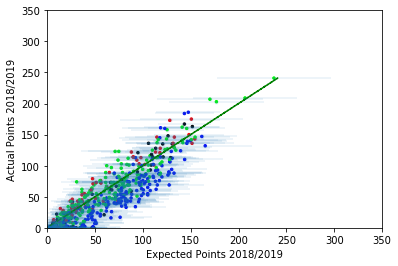

In [87]:
# plot with respect to last seasons points - for those players eligible
y3 = pd.read_csv("../data/players_raw_20182019.csv")
y3['full_name'] = (y3['first_name'] + ' ' + y3['second_name'])
exp_points = np.zeros(len(y3.index))
sd_points = np.zeros(len(y3.index))
cr = np.zeros((len(y3.index), 3))
for i in range(len(y3.index)):
    ind = np.where(y3.loc[y3.index[i], 'full_name'] == all_players_params['player'])[0][0]
    exp_points[i] = C[ind]
    sd_points[i] = S[ind]
    cr[i, :] = np.array([((all_players_params.loc[all_players_params.index[ind], 'position'] == 'FWD')),
                         ((all_players_params.loc[all_players_params.index[ind], 'position'] == 'MID')),
                         ((all_players_params.loc[all_players_params.index[ind], 'position'] == 'DEF'))])

plot.errorbar(exp_points, y3['total_points'] - y3['bonus'], xerr=2 * sd_points, marker='.', linestyle="", alpha=0.1)
plot.scatter(exp_points, y3['total_points'] - y3['bonus'], color=cr, s=6)
plot.plot(y3['total_points'] - y3['bonus'], y3['total_points'] - y3['bonus'], linestyle="--", color='g')
plot.xlim([0, 350])
plot.ylim([0, 350])
plot.xlabel('Expected Points 2018/2019')
plot.ylabel('Actual Points 2018/2019')
plot.show()

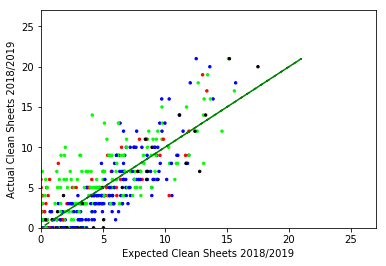

In [88]:
# plot with respect to last seasons clean sheets - for eligble players
clean_sheets = np.zeros(len(y3.index))
for i in range(len(y3.index)):
    ind = np.where(y3.loc[y3.index[i], 'full_name'] == all_players_params['player'])[0][0]
    clean_sheets[i] = CS[ind]

plot.scatter(clean_sheets, y3['clean_sheets'], color=cr, s=6)
plot.plot(y3['clean_sheets'], y3['clean_sheets'], linestyle="--", color='g')
plot.xlim([0, 27])
plot.ylim([0, 27])
plot.xlabel('Expected Clean Sheets 2018/2019')
plot.ylabel('Actual Clean Sheets 2018/2019')
plot.show()

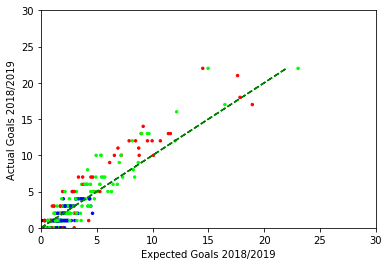

In [89]:
# plot with respect to last seasons goals - for eligble players
goals = np.zeros(len(y3.index))
for i in range(len(y3.index)):
    ind = np.where(y3.loc[y3.index[i], 'full_name'] == all_players_params['player'])[0][0]
    goals[i] = G[ind]

plot.scatter(goals, y3['goals_scored'], color=cr, s=6)
plot.plot(y3['goals_scored'], y3['goals_scored'], linestyle="--", color='g')
plot.xlim([0, 30])
plot.ylim([0, 30])
plot.xlabel('Expected Goals 2018/2019')
plot.ylabel('Actual Goals 2018/2019')
plot.show()

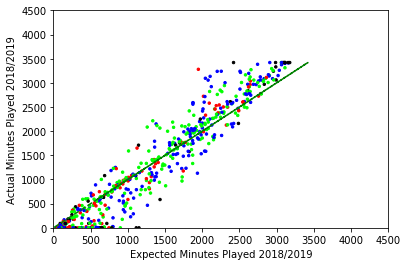

In [90]:
# plot with respect to last seasons mins played - for eligble players
mins_played = np.zeros(len(y3.index))
for i in range(len(y3.index)):
    ind = np.where(y3.loc[y3.index[i], 'full_name'] == all_players_params['player'])[0][0]
    mins_played[i] = MP[ind]

plot.scatter(mins_played, y3['minutes'], s=6, color=cr)
plot.plot(y3['minutes'], y3['minutes'], linestyle="--", color='g')
plot.xlim([0, 4500])
plot.ylim([0, 4500])
plot.xlabel('Expected Minutes Played 2018/2019')
plot.ylabel('Actual Minutes Played 2018/2019')
plot.show()

### Team predictions

Gives predictions for a team's score on a gameweek

In [58]:
# this gameweek fixtures
#fixture_list_this_gw = (pd.read_csv("prem_results_20182019.csv", header=None).as_matrix())[:10, :]
#print(fixture_list_this_gw)

# this gameweek form for each fixture
#form =...

# players for a specific team
tm_players = ['Mohamed Salah', 'James Milner'] #....
new_players_frame = all_players_params[all_players_params['player'].isin(tm_players)]
Niter = 100
C, S = ComputeExpectedPoints(fixture_list_this_gw, teams, new_players_frame, all_teams_params,
                             zerooutbottom=3, Niter=Niter, form=form)  # zero out bench players
expected_tm_score = np.sum(C)
sd_tm_score = np.sqrt(np.sum(S ** 2))
print('expected team score: ', expected_tm_score)
print('lower 95% confidence team score: ', max(0, expected_tm_score - (2 * sd_tm_score)))
print('upper 95% confidence team score: ', expected_tm_score + (2 * sd_tm_score))

---
Realisation  0
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [0. 2.]  points
---
Realisation  1
Top Points Scorers:  310    Mohamed Salah
298     James Milner
Name: player, dtype: object  with  [2. 5.]  points
---
Realisation  2
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [1. 2.]  points
---
Realisation  3
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [ 4. 10.]  points
---
Realisation  4
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [2. 3.]  points
---
Realisation  5
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [0. 3.]  points
---
Realisation  6
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [1. 2.]  points
---
Realisation  7
Top Points Scorers:  298     James Milner
310   

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [ ]:
# calculates match probability
def match_prob(exp_p1, sd_p1, exp_p2, sd_p2):
    exp_diff = exp_p1 - exp_p2
    sd_diff = np.sqrt((sd_p1 ** 2) + (sd_p2 ** 2))
    return(1 - norm.cdf(0, exp_diff, sd_diff))